# 🚲 Bike Sharing Demand Prediction with Weather

---

**Objective:** Predict how many bicycles will arrive at a given station in the next 60 minutes using Zero-Inflated Regression models.

## Table of Contents
* [1. Setup & Configuration](#1.-Setup-&-Configuration)
* [2. Data Processing & Cleaning](#2.-Data-Processing-&-Cleaning)
  * [2.1. Bike Sharing Data](#2.1.-Bike-Sharing-Data)
  * [2.2. Weather Data](#2.2.-Weather-Data)
  * [2.3. Merging](#2.3.-Merging)
* [3. Exploratory Data Analysis (EDA)](#3.-Exploratory-Data-Analysis-(EDA))
* [4. Feature Engineering](#4.-Feature-Engineering)
* [5. Feature Selection](#5.-Feature-Selection)
  * [5.1. Correlation Analysis](#5.1.-Correlation-Analysis)
  * [5.2. Variance Inflation Factor (VIF)](#5.2.-Variance-Inflation-Factor-(VIF))
* [6. Zero-Inflation Analysis](#6.-Zero-Inflation-Analysis)
* [7. Model Configuration](#7.-Model-Configuration)
  * [Zero-Inflated Model Framework](#Zero-Inflated-Model-Framework)
* [8. Model Training](#8.-Model-Training)
* [9. Model Comparison](#9.-Model-Comparison)

## 1. Setup & Configuration

In [50]:
# ══════════════════════════════════════════════════════════════════════════════
# IMPORTS
# ══════════════════════════════════════════════════════════════════════════════

# Data manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch

# Machine Learning
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import (
    RandomForestClassifier, RandomForestRegressor,
    ExtraTreesClassifier, ExtraTreesRegressor,
    GradientBoostingClassifier, GradientBoostingRegressor,
    AdaBoostClassifier
)
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.base import clone

# Zero-Inflated Regressor
from sklego.meta import ZeroInflatedRegressor

# Multicollinearity
from statsmodels.stats.outliers_influence import variance_inflation_factor

# XGBoost
from xgboost import XGBRegressor, XGBClassifier

# LightGBM
from lightgbm import LGBMRegressor, LGBMClassifier

# CatBoost
from catboost import CatBoostRegressor, CatBoostClassifier

# Settings
import warnings
warnings.filterwarnings('ignore')

# Plot style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11

print("All imports successful")

All imports successful


## 2. Data Processing & Cleaning

### 2.1. Bike Sharing Data

In [51]:
trips = pd.read_csv('data/trips.zip')
trips.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2707779 entries, 0 to 2707778
Data columns (total 15 columns):
 #   Column               Dtype  
---  ------               -----  
 0   trip_id              int64  
 1   duration             int64  
 2   start_time           object 
 3   end_time             object 
 4   start_station        int64  
 5   start_lat            float64
 6   start_lon            float64
 7   end_station          int64  
 8   end_lat              float64
 9   end_lon              float64
 10  bike_id              object 
 11  plan_duration        float64
 12  trip_route_category  object 
 13  passholder_type      object 
 14  bike_type            object 
dtypes: float64(5), int64(4), object(6)
memory usage: 309.9+ MB


In [52]:
stations = pd.read_csv('data/stations.zip', sep=';')
stations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 347 entries, 0 to 346
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   station_id    347 non-null    int64 
 1   station_name  347 non-null    object
 2   region        347 non-null    object
 3   status        347 non-null    object
dtypes: int64(1), object(3)
memory usage: 11.0+ KB


In [53]:
trips['start_time'] = pd.to_datetime(trips['start_time'], errors='coerce')
trips['end_time'] = pd.to_datetime(trips['end_time'], errors='coerce')

df_2021 = trips[trips['start_time'].dt.year == 2021]
df_2021.head()

,trip_id,duration,start_time,end_time,start_station,start_lat,start_lon,end_station,end_lat,end_lon,bike_id,plan_duration,trip_route_category,passholder_type,bike_type
1138927,151713183,17,2021-01-01 01:45:00,2021-01-01 02:02:00,3005,34.048500,-118.258537,4304,34.062580,-118.290092,5894,1.0,One Way,Walk-up,standard
1138928,151713983,7,2021-01-01 02:35:00,2021-01-01 02:42:00,4390,34.069271,-118.296593,4456,34.052429,-118.302017,16901,365.0,One Way,Annual Pass,electric
1138929,151716483,8,2021-01-01 04:28:00,2021-01-01 04:36:00,3052,34.051102,-118.264557,4314,34.057709,-118.279762,6005,30.0,One Way,Monthly Pass,standard
1138930,151721185,208,2021-01-01 04:43:00,2021-01-01 08:11:00,3034,34.042061,-118.263382,3031,34.044701,-118.252441,5852,1.0,One Way,Walk-up,standard
1138931,151720984,129,2021-01-01 05:53:00,2021-01-01 08:02:00,4446,34.053230,-118.278419,4446,34.053230,-118.278419,12075,1.0,Round Trip,Walk-up,standard


In [54]:
df_2021['start_station'].eq(3000).sum()
df_2021['end_station'].eq(3000).sum()
df_2021_no_vs = df_2021[
    (df_2021['start_station'] != 3000) &
    (df_2021['end_station'] != 3000)
]

In [55]:
df = df_2021.dropna() # all changes to df_2021 so far
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 214190 entries, 1138927 to 1358850
Data columns (total 15 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   trip_id              214190 non-null  int64         
 1   duration             214190 non-null  int64         
 2   start_time           214190 non-null  datetime64[ns]
 3   end_time             214190 non-null  datetime64[ns]
 4   start_station        214190 non-null  int64         
 5   start_lat            214190 non-null  float64       
 6   start_lon            214190 non-null  float64       
 7   end_station          214190 non-null  int64         
 8   end_lat              214190 non-null  float64       
 9   end_lon              214190 non-null  float64       
 10  bike_id              214190 non-null  object        
 11  plan_duration        214190 non-null  float64       
 12  trip_route_category  214190 non-null  object        
 13  passholder_t

,trip_id,duration,start_time,end_time,start_station,start_lat,start_lon,end_station,end_lat,end_lon,bike_id,plan_duration,trip_route_category,passholder_type,bike_type
1138927,151713183,17,2021-01-01 01:45:00,2021-01-01 02:02:00,3005,34.048500,-118.258537,4304,34.062580,-118.290092,5894,1.0,One Way,Walk-up,standard
1138928,151713983,7,2021-01-01 02:35:00,2021-01-01 02:42:00,4390,34.069271,-118.296593,4456,34.052429,-118.302017,16901,365.0,One Way,Annual Pass,electric
1138929,151716483,8,2021-01-01 04:28:00,2021-01-01 04:36:00,3052,34.051102,-118.264557,4314,34.057709,-118.279762,6005,30.0,One Way,Monthly Pass,standard
1138930,151721185,208,2021-01-01 04:43:00,2021-01-01 08:11:00,3034,34.042061,-118.263382,3031,34.044701,-118.252441,5852,1.0,One Way,Walk-up,standard
1138931,151720984,129,2021-01-01 05:53:00,2021-01-01 08:02:00,4446,34.053230,-118.278419,4446,34.053230,-118.278419,12075,1.0,Round Trip,Walk-up,standard


In [56]:
df = df.drop(columns=['bike_type', 'plan_duration', 'trip_route_category', 'passholder_type'])

df = df[df['duration'] <= 90]

df['end_hour'] = df['end_time'].dt.floor('H')

In [57]:
df_merged = df.merge(
    stations[['station_id', 'station_name', 'region']],
    left_on='end_station',
    right_on='station_id',
    how='left'
)

df_merged = df_merged.drop(columns=['station_id'])

df_merged.head()

,trip_id,duration,start_time,end_time,start_station,start_lat,start_lon,end_station,end_lat,end_lon,bike_id,end_hour,station_name,region
0,151713183,17,2021-01-01 01:45:00,2021-01-01 02:02:00,3005,34.048500,-118.258537,4304,34.062580,-118.290092,5894,2021-01-01 02:00:00,Shatto Pl & Wilshire,DTLA
1,151713983,7,2021-01-01 02:35:00,2021-01-01 02:42:00,4390,34.069271,-118.296593,4456,34.052429,-118.302017,16901,2021-01-01 02:00:00,Ardmore & Olympic,DTLA
2,151716483,8,2021-01-01 04:28:00,2021-01-01 04:36:00,3052,34.051102,-118.264557,4314,34.057709,-118.279762,6005,2021-01-01 04:00:00,7th & Park View,DTLA
3,151721684,43,2021-01-01 07:53:00,2021-01-01 08:36:00,4210,33.984341,-118.471550,4210,33.984341,-118.471550,16914,2021-01-01 08:00:00,Ocean Front Walk & North Venice,Westside
4,151721683,39,2021-01-01 07:57:00,2021-01-01 08:36:00,4210,33.984341,-118.471550,4210,33.984341,-118.471550,17334,2021-01-01 08:00:00,Ocean Front Walk & North Venice,Westside


In [58]:
def haversine(lat1, lon1, lat2, lon2):
    R = 6371.0  # Mean radius of Earth in kilometres

    phi1 = np.radians(lat1)
    phi2 = np.radians(lat2)
    dphi = np.radians(lat2 - lat1)
    dlambda = np.radians(lon2 - lon1)

    a = np.sin(dphi / 2.0) ** 2 + np.cos(phi1) * np.cos(phi2) * np.sin(dlambda / 2.0) ** 2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

    return R * c

In [59]:
df_merged['distance_km'] = haversine(
    df_merged['start_lat'],
    df_merged['start_lon'],
    df_merged['end_lat'],
    df_merged['end_lon']
)

In [60]:
df_merge = df_merged[df_merged['distance_km'] <= 10] #trips less than 10 km in 1.5h

In [61]:
df_end_hourly = (
    df_merge
    .groupby(['end_hour', 'end_station', 'station_name', 'region'])
    .agg(
        count=('duration', 'size'),
        avg_duration=('duration', 'mean'),
        avg_distance=('distance_km', 'mean')
    )
    .reset_index()
    .sort_values(['end_station', 'end_hour'])
)

df_end_hourly = df_end_hourly.set_index('end_hour')

In [62]:
resampled_list = []

for station, group in df_end_hourly.groupby('end_station'):
    # ensure full hourly continuity for this station
    station_resampled = group.resample('1H').asfreq()

    # re-attach static station metadata
    station_resampled['end_station'] = station
    station_resampled['station_name'] = group['station_name'].iloc[0]
    station_resampled['region'] = group['region'].iloc[0]

    resampled_list.append(station_resampled)

df_end_resampled = pd.concat(resampled_list).reset_index()

In [63]:
df_end_resampled['count'] = df_end_resampled['count'].fillna(0)
df_end_resampled['avg_duration'] = df_end_resampled['avg_duration'].fillna(0)
df_end_resampled['avg_distance'] = df_end_resampled['avg_distance'].fillna(0)

df_end_resampled.head()

,end_hour,end_station,station_name,region,count,avg_duration,avg_distance
0,2021-01-01 13:00:00,3005,7th & Flower,DTLA,1.0,15.0,2.29439
1,2021-01-01 14:00:00,3005,7th & Flower,DTLA,0.0,0.0,0.00000
2,2021-01-01 15:00:00,3005,7th & Flower,DTLA,0.0,0.0,0.00000
3,2021-01-01 16:00:00,3005,7th & Flower,DTLA,0.0,0.0,0.00000
4,2021-01-01 17:00:00,3005,7th & Flower,DTLA,0.0,0.0,0.00000


In [64]:
# Sort correctly to ensure a coherent time sequence per station
df_end_resampled = df_end_resampled.sort_values(['end_station', 'end_hour'])

# Shift count by –1 within each station’s time-series
df_end_resampled['next_count'] = (
    df_end_resampled.groupby('end_station')['count'].shift(-1)
)

### 2.2. Weather Data

In [65]:
weather = pd.read_csv("data/weather.zip")

weather["rain_1h"] = weather["rain_1h"].fillna(0)

weather["rain_3h"] = weather["rain_3h"].fillna(0)

weather["wind_gust"] = weather["wind_gust"].fillna(0)


weather = weather.drop(columns=["snow_1h", "snow_3h", "grnd_level", 
                      "sea_level", "city_name", "lat", 
                      "lon", "weather_icon", "dt", "timezone"])

weather.info()

weather.to_csv('data/weather_clean.zip', index=False, compression='zip')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86465 entries, 0 to 86464
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   dt_iso               86465 non-null  object 
 1   temp                 86465 non-null  float64
 2   visibility           68229 non-null  float64
 3   feels_like           86465 non-null  float64
 4   pressure             86465 non-null  int64  
 5   humidity             86465 non-null  int64  
 6   wind_speed           86465 non-null  float64
 7   wind_deg             86465 non-null  int64  
 8   wind_gust            86465 non-null  float64
 9   rain_1h              86465 non-null  float64
 10  rain_3h              86465 non-null  float64
 11  clouds_all           86465 non-null  int64  
 12  weather_id           86465 non-null  int64  
 13  weather_main         86465 non-null  object 
 14  weather_description  86465 non-null  object 
dtypes: float64(7), int64(5), object(3)
m

In [66]:
# Remove trailing timezone text
weather['dt_iso'] = weather['dt_iso'].str.replace(r' \+0000 UTC', '', regex=True)

# Convert to datetime (no timezone info)
weather['dt_iso'] = pd.to_datetime(weather['dt_iso'])


In [67]:
weather['weather_hour'] = weather['dt_iso'].dt.floor('H')

### 2.3. Merging

In [68]:
df = df_end_resampled.merge(
    weather,
    left_on='end_hour',
    right_on='weather_hour',
    how='left'
)

df = df.drop(columns="dt_iso")

In [69]:
df.to_csv('final_data/data_with_weather.zip', index=False, compression='zip')

In [70]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1788967 entries, 0 to 1788966
Data columns (total 23 columns):
 #   Column               Dtype         
---  ------               -----         
 0   end_hour             datetime64[ns]
 1   end_station          int64         
 2   station_name         object        
 3   region               object        
 4   count                float64       
 5   avg_duration         float64       
 6   avg_distance         float64       
 7   next_count           float64       
 8   temp                 float64       
 9   visibility           float64       
 10  feels_like           float64       
 11  pressure             int64         
 12  humidity             int64         
 13  wind_speed           float64       
 14  wind_deg             int64         
 15  wind_gust            float64       
 16  rain_1h              float64       
 17  rain_3h              float64       
 18  clouds_all           int64         
 19  weather_id           

In [71]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1788967 entries, 0 to 1788966
Data columns (total 23 columns):
 #   Column               Dtype         
---  ------               -----         
 0   end_hour             datetime64[ns]
 1   end_station          int64         
 2   station_name         object        
 3   region               object        
 4   count                float64       
 5   avg_duration         float64       
 6   avg_distance         float64       
 7   next_count           float64       
 8   temp                 float64       
 9   visibility           float64       
 10  feels_like           float64       
 11  pressure             int64         
 12  humidity             int64         
 13  wind_speed           float64       
 14  wind_deg             int64         
 15  wind_gust            float64       
 16  rain_1h              float64       
 17  rain_3h              float64       
 18  clouds_all           int64         
 19  weather_id           

## 3. Exploratory Data Analysis (EDA)

## 4. Feature Engineering

In [72]:
# ══════════════════════════════════════════════════════════════════════════════
# DATA CLEANING
# ══════════════════════════════════════════════════════════════════════════════

# Drop redundant column
df = df.drop(columns=['weather_hour'])

print("Dropped 'weather_hour' column")

Dropped 'weather_hour' column


In [73]:
# ══════════════════════════════════════════════════════════════════════════════
# CREATE TIME-BASED FEATURES
# ══════════════════════════════════════════════════════════════════════════════

def get_season(month):
    """Map month to season."""
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'

# Extract temporal features
df['end_month'] = df['end_hour'].dt.month
df['season'] = df['end_month'].apply(get_season)
df['day_of_week'] = df['end_hour'].dt.dayofweek
df['business_day'] = df['day_of_week'] < 5
df['hour_of_day'] = df['end_hour'].dt.hour

print("Created features: end_month, season, day_of_week, business_day, hour_of_day")

Created features: end_month, season, day_of_week, business_day, hour_of_day


In [74]:
# ══════════════════════════════════════════════════════════════════════════════
# HANDLE MISSING VALUES
# ══════════════════════════════════════════════════════════════════════════════

print("Missing Values:")
missing = df.isnull().sum()
print(missing[missing > 0])

# Fill visibility with mode
if df['visibility'].isnull().sum() > 0:
    visibility_mode = df['visibility'].mode()[0]
    df['visibility'] = df['visibility'].fillna(visibility_mode)
    print(f"\nFilled visibility NaN with mode: {visibility_mode}")

# Drop rows where target is null
initial_rows = len(df)
df = df.dropna(subset=['next_count'])
print(f"df: Dropped {initial_rows - len(df)} rows with null target")

Missing Values:
next_count       231
visibility    226644
dtype: int64

Filled visibility NaN with mode: 10000.0
df: Dropped 231 rows with null target


## 5. Feature Selection

### 5.1. Correlation Analysis

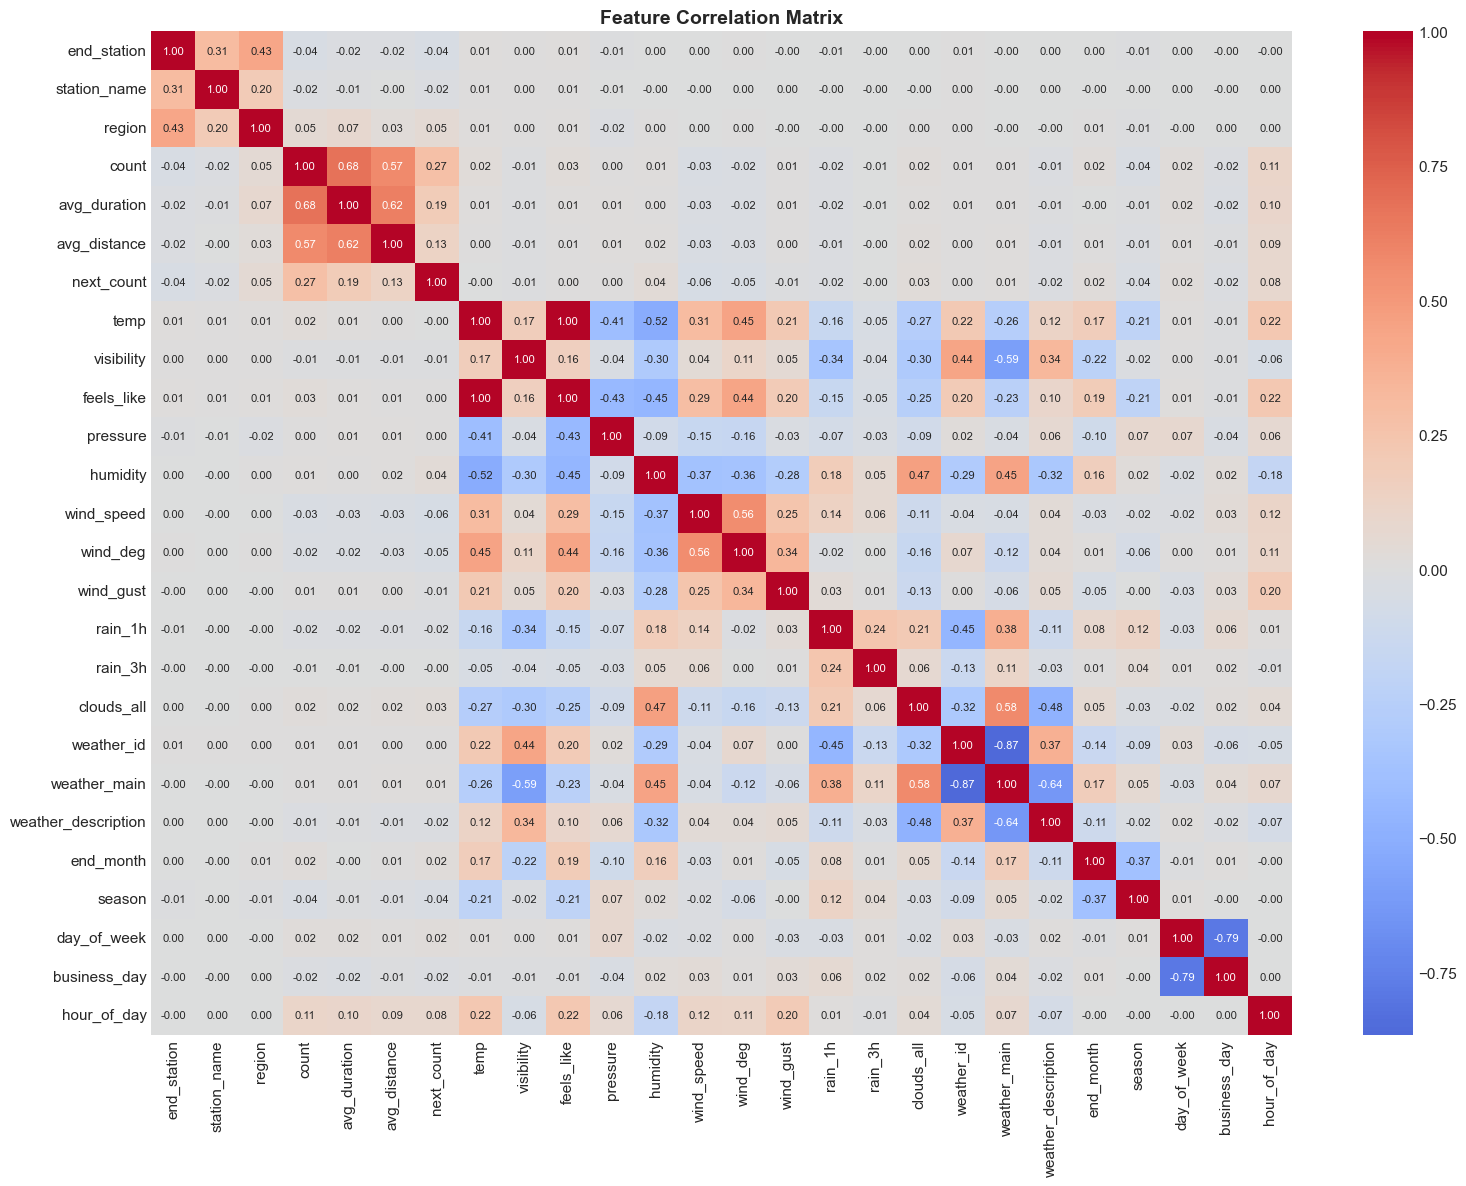

In [75]:
# ══════════════════════════════════════════════════════════════════════════════
# CORRELATION MATRIX
# ══════════════════════════════════════════════════════════════════════════════

# Prepare encoded dataframe for correlation
df_encoded = df.drop(columns=['end_hour']).copy()

# Encode categorical columns
for col in df_encoded.select_dtypes(include=['object']).columns:
    df_encoded[col] = df_encoded[col].astype('category').cat.codes

# Convert bool to int
df_encoded['business_day'] = df_encoded['business_day'].astype(int)

# Calculate correlation
corr_matrix = df_encoded.corr()

# Plot heatmap (full matrix)
plt.figure(figsize=(16, 12))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, annot_kws={'size': 8})
plt.title('Feature Correlation Matrix', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

In [76]:
# ══════════════════════════════════════════════════════════════════════════════
# IDENTIFY HIGHLY CORRELATED PAIRS (> 0.8)
# ══════════════════════════════════════════════════════════════════════════════

target = 'next_count'
threshold = 0.8

print(f"Highly Correlated Pairs (|r| > {threshold}):")
print("-" * 50)

high_corr_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if abs(corr_matrix.iloc[i, j]) > threshold:
            col1, col2 = corr_matrix.columns[i], corr_matrix.columns[j]
            corr_val = corr_matrix.iloc[i, j]
            high_corr_pairs.append((col1, col2, corr_val))
            print(f"{col1} ↔ {col2}: {corr_val:.3f}")

Highly Correlated Pairs (|r| > 0.8):
--------------------------------------------------
temp ↔ feels_like: 0.996
weather_id ↔ weather_main: -0.866


In [77]:
# ══════════════════════════════════════════════════════════════════════════════
# DROP HIGHLY CORRELATED FEATURES (keep one with higher target correlation)
# ══════════════════════════════════════════════════════════════════════════════

cols_to_drop = set()

for col1, col2, _ in high_corr_pairs:
    if col1 == target or col2 == target:
        continue
    corr1 = abs(corr_matrix.loc[col1, target])
    corr2 = abs(corr_matrix.loc[col2, target])
    drop_col = col1 if corr1 < corr2 else col2
    cols_to_drop.add(drop_col)

print("Features to Drop (lower correlation with target):")
for col in cols_to_drop:
    print(f"  • {col}")

Features to Drop (lower correlation with target):
  • weather_id
  • temp


### 5.2. Variance Inflation Factor (VIF)

In [78]:
# ══════════════════════════════════════════════════════════════════════════════
# CALCULATE VIF
# ══════════════════════════════════════════════════════════════════════════════

# Prepare data for VIF (exclude target and highly correlated)
df_vif = df_encoded.drop(columns=[target, 'end_station', 'station_name', 'region'] + list(cols_to_drop)).dropna()

# Use sample for faster computation
df_vif_sample = df_vif.sample(n=min(100000, len(df_vif)), random_state=42)

# Calculate VIF
vif_data = pd.DataFrame()
vif_data['Feature'] = df_vif_sample.columns
vif_data['VIF'] = [variance_inflation_factor(df_vif_sample.values, i) 
                   for i in range(df_vif_sample.shape[1])]
vif_data = vif_data.sort_values('VIF', ascending=False)

print("Variance Inflation Factor (VIF):")
print("-" * 40)
print(vif_data.to_string(index=False))
print("\nVIF Interpretation: <5 (Low), 5-10 (Moderate), >10 (High)")

Variance Inflation Factor (VIF):
----------------------------------------
            Feature        VIF
           pressure 187.166975
         visibility  83.207980
           humidity  19.890058
         feels_like  17.314692
weather_description  15.735139
       business_day   9.372200
        day_of_week   8.743234
          end_month   6.485747
        hour_of_day   4.330684
       weather_main   4.115314
             season   3.493785
           wind_deg   2.997543
         wind_speed   2.957418
         clouds_all   2.533493
       avg_duration   2.162607
              count   1.923728
       avg_distance   1.803165
            rain_1h   1.442454
          wind_gust   1.374638
            rain_3h   1.091449

VIF Interpretation: <5 (Low), 5-10 (Moderate), >10 (High)


In [79]:
# ══════════════════════════════════════════════════════════════════════════════
# SELECT FEATURES WITH VIF < 5
# ══════════════════════════════════════════════════════════════════════════════

# Keep essential columns regardless of VIF
essential_cols = ['end_station', 'station_name', 'region']

# Features to drop based on VIF
drop_features = vif_data[(vif_data['VIF'] >= 5) & 
                          (~vif_data['Feature'].isin(essential_cols))]['Feature'].tolist()

print("Features to Drop (VIF ≥ 5):")
for col in drop_features:
    vif_val = vif_data[vif_data['Feature'] == col]['VIF'].values[0]
    print(f"  • {col} (VIF: {vif_val:.2f})")

# Apply feature selection
all_drops = list(cols_to_drop) + drop_features
all_drops = [c for c in all_drops if c in df.columns]
df = df.drop(columns=all_drops)

print(f"\nDropped {len(all_drops)} features")
print(f"Remaining features: {df.shape[1]}")

Features to Drop (VIF ≥ 5):
  • pressure (VIF: 187.17)
  • visibility (VIF: 83.21)
  • humidity (VIF: 19.89)
  • feels_like (VIF: 17.31)
  • weather_description (VIF: 15.74)
  • business_day (VIF: 9.37)
  • day_of_week (VIF: 8.74)
  • end_month (VIF: 6.49)



Dropped 10 features
Remaining features: 17


In [80]:
# Final dataset overview
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1788736 entries, 0 to 1788965
Data columns (total 17 columns):
 #   Column        Dtype         
---  ------        -----         
 0   end_hour      datetime64[ns]
 1   end_station   int64         
 2   station_name  object        
 3   region        object        
 4   count         float64       
 5   avg_duration  float64       
 6   avg_distance  float64       
 7   next_count    float64       
 8   wind_speed    float64       
 9   wind_deg      int64         
 10  wind_gust     float64       
 11  rain_1h       float64       
 12  rain_3h       float64       
 13  clouds_all    int64         
 14  weather_main  object        
 15  season        object        
 16  hour_of_day   int32         
dtypes: datetime64[ns](1), float64(8), int32(1), int64(3), object(4)
memory usage: 238.8+ MB


In [81]:
result = (
    df.groupby('region')
      .agg(
          mean_non_zero=('count', lambda x: x[x != 0].mean()),
          max=('count', 'max')
      )
      .reset_index()
)

result

,region,mean_non_zero,max
0,DTLA,1.362134,41.0
1,North Hollywood,1.154074,6.0
2,Westside,1.843628,24.0


## 6. Zero-Inflation Analysis

══════════════════════════════════════════════════
ZERO-INFLATION ANALYSIS
══════════════════════════════════════════════════
Total Samples:     1,788,736
Zero Values:       1,658,853 (92.74%)
Non-Zero Values:   129,883 (7.26%)


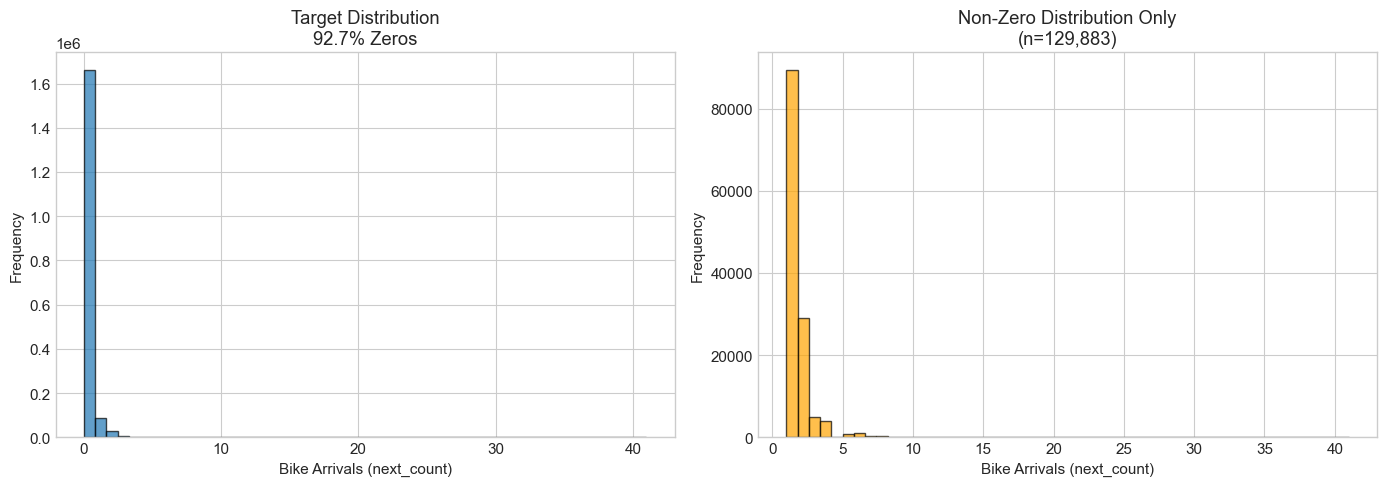

In [82]:
# ══════════════════════════════════════════════════════════════════════════════
# ANALYZE TARGET VARIABLE DISTRIBUTION
# ══════════════════════════════════════════════════════════════════════════════

zero_count = (df['next_count'] == 0).sum()
total_count = len(df)
zero_pct = zero_count / total_count * 100

print("═" * 50)
print("ZERO-INFLATION ANALYSIS")
print("═" * 50)
print(f"Total Samples:     {total_count:,}")
print(f"Zero Values:       {zero_count:,} ({zero_pct:.2f}%)")
print(f"Non-Zero Values:   {total_count - zero_count:,} ({100 - zero_pct:.2f}%)")

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Full distribution
axes[0].hist(df['next_count'], bins=50, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Bike Arrivals (next_count)')
axes[0].set_ylabel('Frequency')
axes[0].set_title(f'Target Distribution\n{zero_pct:.1f}% Zeros')

# Non-zero distribution
non_zero = df[df['next_count'] > 0]['next_count']
axes[1].hist(non_zero, bins=50, edgecolor='black', alpha=0.7, color='orange')
axes[1].set_xlabel('Bike Arrivals (next_count)')
axes[1].set_ylabel('Frequency')
axes[1].set_title(f'Non-Zero Distribution Only\n(n={len(non_zero):,})')

plt.tight_layout()
plt.show()

## 7. Model Configuration

### Zero-Inflated Model Framework

The Zero-Inflated Model is a meta-regressor that handles datasets with many zeros:
1. **Classification Task:** Determines if output is zero or non-zero
2. **Regression Task:** Predicts the actual value (only for non-zero predictions)

| Model | Classifier | Regressor |
|-------|------------|----------|
| ZIR 1 | Decision Tree | Decision Tree |
| ZIR 1.2 | AdaBoost (DT) | Decision Tree |
| ZIR 2 | Random Forest | Random Forest |
| ZIR 3 | Extra Trees | Extra Trees |
| ZIR 4 | Gradient Boosting | Gradient Boosting |
| ZIR 5 | XGBoost | XGBoost |
| ZIR 6 | LightGBM | LightGBM |
| ZIR 7 | CatBoost | CatBoost |

In [83]:
MODELS = {
    # Baseline Models (Plain Regressors)
    'BASELINE_DT': {
        'type': 'plain',
        'regressor': DecisionTreeRegressor(random_state=42)
    },
    'BASELINE_RF': {
        'type': 'plain',
        'regressor': RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
    },
    'BASELINE_GB': {
        'type': 'plain',
        'regressor': GradientBoostingRegressor(n_estimators=100, random_state=42)
    },
    'BASELINE_XGB': {
        'type': 'plain',
        'regressor': XGBRegressor(n_estimators=100, random_state=42, n_jobs=-1, verbosity=0)
    },
    'BASELINE_LGBM': {
        'type': 'plain',
        'regressor': LGBMRegressor(n_estimators=100, random_state=42, n_jobs=-1, verbosity=-1)
    },
    'BASELINE_CATBOOST': {
        'type': 'plain',
        'regressor': CatBoostRegressor(iterations=100, random_state=42, verbose=False)
    },
    'BASELINE_ET': {
        'type': 'plain',
        'regressor': ExtraTreesRegressor(n_estimators=100, random_state=42, n_jobs=-1)
    },
    
    # Zero-Inflated Regression Models
    'ZIR_1': {
        'type': 'zir',
        'classifier': DecisionTreeClassifier(random_state=42),
        'regressor': DecisionTreeRegressor(random_state=42)
    },
    'ZIR_1.2': {
        'type': 'zir',
        'classifier': AdaBoostClassifier(
            estimator=DecisionTreeClassifier(max_depth=3, random_state=42),
            n_estimators=50, random_state=42
        ),
        'regressor': DecisionTreeRegressor(random_state=42)
    },
    'ZIR_2': {
        'type': 'zir',
        'classifier': RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
        'regressor': RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
    },
    'ZIR_3': {
        'type': 'zir',
        'classifier': ExtraTreesClassifier(n_estimators=100, random_state=42, n_jobs=-1),
        'regressor': ExtraTreesRegressor(n_estimators=100, random_state=42, n_jobs=-1)
    },
    'ZIR_4': {
        'type': 'zir',
        'classifier': GradientBoostingClassifier(n_estimators=100, random_state=42),
        'regressor': GradientBoostingRegressor(n_estimators=100, random_state=42)
    },
    'ZIR_5_XGB': {
        'type': 'zir',
        'classifier': XGBClassifier(n_estimators=100, random_state=42, n_jobs=-1, verbosity=0),
        'regressor': XGBRegressor(n_estimators=100, random_state=42, n_jobs=-1, verbosity=0)
    },
    'ZIR_6_LGBM': {
        'type': 'zir',
        'classifier': LGBMClassifier(n_estimators=100, random_state=42, n_jobs=-1, verbosity=-1),
        'regressor': LGBMRegressor(n_estimators=100, random_state=42, n_jobs=-1, verbosity=-1)
    },
    'ZIR_7_CATBOOST': {
        'type': 'zir',
        'classifier': CatBoostClassifier(iterations=100, random_state=42, verbose=False),
        'regressor': CatBoostRegressor(iterations=100, random_state=42, verbose=False)
    }
}

SPLIT_RATIOS = [0.80]

## 8. Model Training

In [84]:
# ══════════════════════════════════════════════════════════════════════════════
# EXPERIMENT FUNCTION
# ══════════════════════════════════════════════════════════════════════════════

def run_experiment(df, region_name, n_stations=None, random_state=42):
    """
    Run Zero-Inflated Regression experiment for a region.
    
    Parameters:
    -----------
    df : DataFrame
        Full dataset
    region_name : str
        Region to filter (or 'all' for all regions)
    n_stations : int, optional
        Number of random stations to sample (None = all stations)
    random_state : int
        Random seed for reproducibility
    
    Returns:
    --------
    DataFrame with results
    """
    
    # Filter region
    if region_name == 'all':
        df_region = df.copy()
    else:
        df_region = df[df['region'] == region_name].copy()
    
    # Get valid stations (>= 500 samples)
    station_counts = df_region.groupby('end_station').size()
    valid_stations = station_counts[station_counts >= 500].index.tolist()
    
    # Sample stations if requested
    if n_stations and n_stations < len(valid_stations):
        np.random.seed(random_state)
        valid_stations = np.random.choice(valid_stations, size=n_stations, replace=False)
    
    print("═" * 60)
    print(f"EXPERIMENT: {region_name.upper()}")
    print("═" * 60)
    print(f"Total stations: {len(valid_stations)}")
    
    # Feature columns
    exclude_cols = ['end_hour', 'end_station', 'station_name', 'region', 'next_count']
    feature_cols = [col for col in df_region.columns if col not in exclude_cols]
    print(f"Features: {feature_cols}")
    
    # Store results
    all_results = []
    best_params_log = []
    
    for idx, station_id in enumerate(valid_stations):
        # Prepare station data
        df_station = df_region[df_region['end_station'] == station_id].copy()
        df_station = df_station.sort_values('end_hour').reset_index(drop=True)
        station_region = df_station['region'].iloc[0]
        
        # Prepare features
        X = df_station[feature_cols].copy()
        y = df_station['next_count'].copy()
        
        # Encode categorical
        for col in X.select_dtypes(include=['object']).columns:
            X[col] = X[col].astype('category').cat.codes
        
        # Drop NaN
        mask = ~(X.isnull().any(axis=1) | y.isnull())
        X, y = X[mask], y[mask]
        
        # Test each split ratio
        for split_ratio in SPLIT_RATIOS:
            split_idx = int(len(X) * split_ratio)
            X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
            y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]
            
            if len(X_test) < 50 or len(X_train) < 100:
                continue
            
            # Scale
            scaler = StandardScaler()
            X_train_scaled = scaler.fit_transform(X_train)
            X_test_scaled = scaler.transform(X_test)
            
            # Test each model
            for model_name, model_config in MODELS.items():
        
                try:
                    if model_config['type'] == 'plain':
                        model = clone(model_config['regressor'])
                    else:
                        model = ZeroInflatedRegressor(
                            classifier=clone(model_config['classifier']),
                            regressor=clone(model_config['regressor'])
                        )

                    model.fit(X_train_scaled, y_train)

                    # Predictions on test (validation) set
                    y_pred = model.predict(X_test_scaled)
                    
                    # Predictions on training set
                    y_pred_train = model.predict(X_train_scaled)

                    
                    # ════════════════════════════════════════════════
                    # FIXED METRICS FOR ZERO-INFLATED DATA
                    # ════════════════════════════════════════════════
                    # Validation metrics
                    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
                    mae = mean_absolute_error(y_test, y_pred)
                    
                    # Training metrics
                    rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
                    mae_train = mean_absolute_error(y_train, y_pred_train)

                    # Accuracy on zeros (classification aspect)
                    zero_accuracy = np.mean(
                        (y_test == 0) == (y_pred < 0.5)
                    ) * 100
                    
                    all_results.append({
                        'region': station_region,
                        'station': station_id,
                        'split': f"{round(split_ratio*100)}-{round((1-split_ratio)*100)}",
                        'model': model_name,
                        'Train_RMSE': rmse_train,
                        'Train_MAE': mae_train,
                        'Val_RMSE': rmse,
                        'Val_MAE': mae,
                        'Zero_Acc': zero_accuracy,
                        'y_true': y_test.values,
                        'y_pred': y_pred,
                        'end_hour': df_station.loc[y_test.index, 'end_hour'].values
                    })
                except Exception as e:
                    continue
        
        print(f"  [{idx+1}/{len(valid_stations)}] Station {station_id} ✓")
        
    params_df = pd.DataFrame(best_params_log)
    
    return pd.DataFrame(all_results)

In [85]:
# ══════════════════════════════════════════════════════════════════════════════
# RUN EXPERIMENT
# ══════════════════════════════════════════════════════════════════════════════

# Option 1: Single region
results = run_experiment(df, region_name='North Hollywood')

# Option 2: Random sample of stations
# results = run_experiment(df, region_name='all', n_stations=25)

# Option 3: All regions
# results = run_experiment(df, region_name='all')

# Save results
results.to_csv('results/results_with_weather.csv', index=False)
print(f"\nResults saved: {len(results):,} experiments")

════════════════════════════════════════════════════════════
EXPERIMENT: NORTH HOLLYWOOD
════════════════════════════════════════════════════════════
Total stations: 23
Features: ['count', 'avg_duration', 'avg_distance', 'wind_speed', 'wind_deg', 'wind_gust', 'rain_1h', 'rain_3h', 'clouds_all', 'weather_main', 'season', 'hour_of_day']
  [1/23] Station 4413 ✓
  [2/23] Station 4414 ✓
  [3/23] Station 4415 ✓
  [4/23] Station 4416 ✓
  [5/23] Station 4417 ✓
  [6/23] Station 4418 ✓
  [7/23] Station 4419 ✓
  [8/23] Station 4420 ✓
  [9/23] Station 4422 ✓
  [10/23] Station 4425 ✓
  [11/23] Station 4426 ✓
  [12/23] Station 4427 ✓
  [13/23] Station 4428 ✓
  [14/23] Station 4429 ✓
  [15/23] Station 4430 ✓
  [16/23] Station 4431 ✓
  [17/23] Station 4432 ✓
  [18/23] Station 4463 ✓
  [19/23] Station 4497 ✓
  [20/23] Station 4498 ✓
  [21/23] Station 4499 ✓
  [22/23] Station 4500 ✓
  [23/23] Station 4502 ✓

Results saved: 345 experiments


## 9. Model Comparison

In [86]:
# ══════════════════════════════════════════════════════════════════════════════
# AGGREGATE RESULTS
# ══════════════════════════════════════════════════════════════════════════════

summary_model = results.groupby('model').agg({
    'Train_RMSE': 'mean',
    'Train_MAE': 'mean',
    'Val_RMSE': 'mean',
    'Val_MAE': 'mean',
    'Zero_Acc': 'mean'
})

print("═" * 70)
print("BY MODEL")
print("═" * 70)
print(summary_model.to_string())

# ══════════════════════════════════════════════════════════════════════════════
# COMPARISON WITH THESIS
# ══════════════════════════════════════════════════════════════════════════════

thesis_results = pd.DataFrame({
    'Model': ['BASELINE_DT', 'ZIR_1', 'ZIR_1.2', 'BASELINE_RF', 'ZIR_2', 
              'ZIR_3', 'BASELINE_GB', 'ZIR_4', 'ZIR_5', 'ZIR_6', 'ZIR_7'],
    'Thesis_RMSE': [0.0777, 0.0721, 0.0701, 0.0733, 0.0669, 0.0686, 0.0690, 0.0667, None, None, None],
    'Thesis_MAE': [0.0173, 0.0068, 0.0066, 0.0177, 0.0060, 0.0063, 0.0182, 0.0061, None, None, None]
})

our_results = summary_model.reset_index()
our_results.columns = [
    'Model', 'Train_RMSE', 'Train_MAE', 'Val_RMSE', 'Val_MAE', 'Zero_Acc'
]

comparison = thesis_results.merge(
    our_results[['Model', 'Train_RMSE', 'Train_MAE', 'Val_RMSE', 'Val_MAE']], 
    on='Model', 
    how='left'
)

print("\n" + "═" * 70)
print("COMPARISON WITH THESIS")
print("═" * 70)
print(comparison.to_string(index=False))

print("\n" + "═" * 70)
print("OUR FULL RESULTS")
print("═" * 70)
print(our_results.to_string(index=False))

══════════════════════════════════════════════════════════════════════
BY MODEL
══════════════════════════════════════════════════════════════════════
                   Train_RMSE  Train_MAE  Val_RMSE   Val_MAE   Zero_Acc
model                                                                  
BASELINE_CATBOOST    0.095086   0.020566  0.080405  0.017708  99.546882
BASELINE_DT          0.077987   0.010423  0.113711  0.015544  98.881829
BASELINE_ET          0.077987   0.010423  0.086967  0.015722  99.448108
BASELINE_GB          0.104480   0.021334  0.078390  0.015467  99.546000
BASELINE_LGBM        0.102365   0.023446  0.078242  0.019978  99.641928
BASELINE_RF          0.085073   0.015294  0.085995  0.016826  99.429494
BASELINE_XGB         0.082052   0.015984  0.095573  0.023351  99.375779
ZIR_1                0.084426   0.006162  0.124607  0.012934  98.970054
ZIR_1.2              0.114829   0.011397  0.070647  0.004327  99.651054
ZIR_2                0.085618   0.006677  0.074339  0.004

In [87]:
# ══════════════════════════════════════════════════════════════════════════════
# ZIR IMPROVEMENT OVER BASELINES
# ══════════════════════════════════════════════════════════════════════════════

pairs = [
    ('ZIR_1', 'BASELINE_DT', 'Decision Tree'),
    ('ZIR_2', 'BASELINE_RF', 'Random Forest'),
    ('ZIR_4', 'BASELINE_GB', 'Gradient Boosting')
]

print("═" * 60)
print("ZIR IMPROVEMENT OVER BASELINES (MAE Reduction)")
print("═" * 60)

for zir, baseline, name in pairs:
    if zir in summary_model.index and baseline in summary_model.index:
        zir_mae = summary_model.loc[zir, 'Val_MAE']
        base_mae = summary_model.loc[baseline, 'Val_MAE']
        improvement = (base_mae - zir_mae) / base_mae * 100
        print(f"{name:20} | {zir} vs {baseline}: {improvement:+.1f}%")

════════════════════════════════════════════════════════════
ZIR IMPROVEMENT OVER BASELINES (MAE Reduction)
════════════════════════════════════════════════════════════
Decision Tree        | ZIR_1 vs BASELINE_DT: +16.8%
Random Forest        | ZIR_2 vs BASELINE_RF: +71.8%
Gradient Boosting    | ZIR_4 vs BASELINE_GB: +64.3%


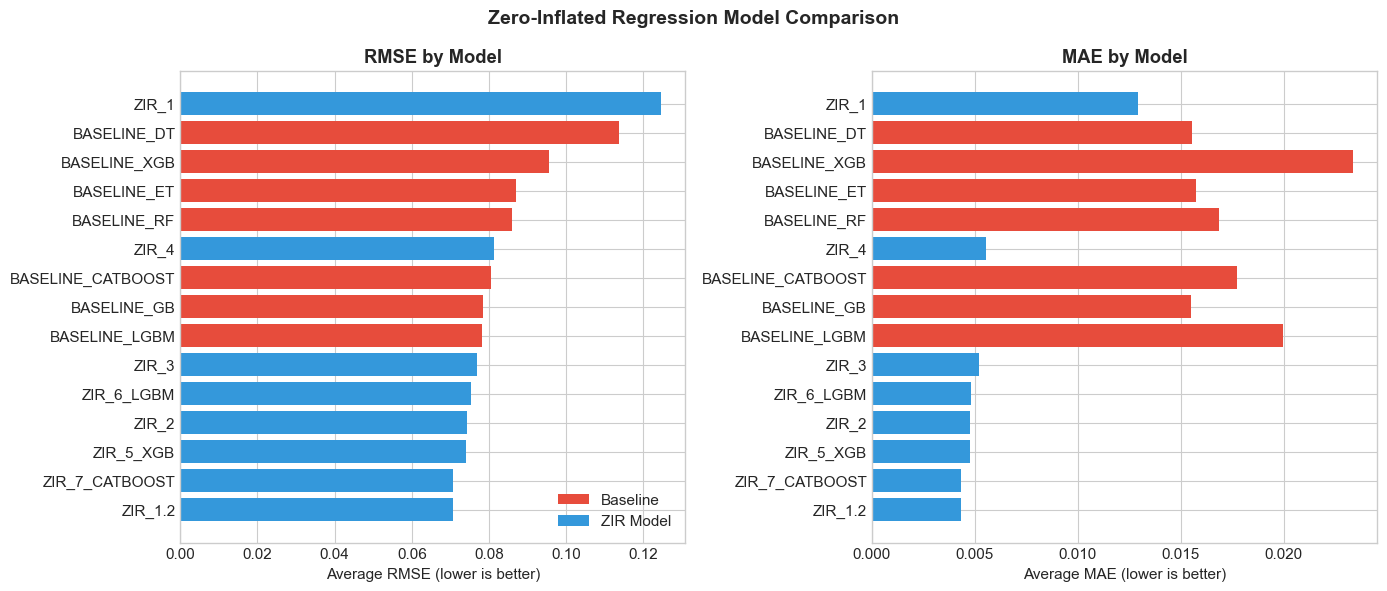

In [88]:
# ══════════════════════════════════════════════════════════════════════════════
# MODEL COMPARISON PLOTS
# ══════════════════════════════════════════════════════════════════════════════

summary = summary_model

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

summary_sorted = summary.sort_values('Val_RMSE')
colors = ['#E74C3C' if 'BASELINE' in x else '#3498DB' for x in summary_sorted.index]

# RMSE Comparison
axes[0].barh(summary_sorted.index, summary_sorted['Val_RMSE'], color=colors)
axes[0].set_xlabel('Average RMSE (lower is better)')
axes[0].set_title('RMSE by Model', fontweight='bold')

# MAE Comparison
axes[1].barh(summary_sorted.index, summary_sorted['Val_MAE'], color=colors)
axes[1].set_xlabel('Average MAE (lower is better)')
axes[1].set_title('MAE by Model', fontweight='bold')

# Legend
legend_elements = [
    Patch(facecolor='#E74C3C', label='Baseline'),
    Patch(facecolor='#3498DB', label='ZIR Model')
]
axes[0].legend(handles=legend_elements, loc='lower right')

plt.suptitle('Zero-Inflated Regression Model Comparison', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()